In [1]:
import numpy as np
from numpy import trace, dot, pi, exp

from scipy.stats import sem
from scipy.linalg import norm, expm, kron
from scipy.optimize import minimize

from functools import reduce
from itertools import product

import random

from qiskit import Aer, QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit.quantum_info import Operator

import matplotlib.pyplot as plt

In [2]:
s0 = np.array([1, 0]) # |0>
s1 = np.array([0, 1]) # |1>
P_0 = np.array([[1,0],[0,0]]) # |0><0|
P_1 = np.array([[0,0],[0,1]]) # |1><1|
X_np = np.array([[0.,1.],
                 [1.,0.]]) # X Pauli matrix
Y_np = np.array([[0.,-1.j],
                 [1.j, 0.]]) # Y Pauli matrix
Z_np = np.array([[1., 0.],
                 [0.,-1.]]) # Z Pauli matrix
I_np = np.array([[1.,0.],
                 [0.,1.]]) # 2x2 identity matrix
H_np = (X_np + Z_np)/np.sqrt(2) # Hadamard gate
S_np = np.array([[1.,0. ],
                 [0.,1.j]]) # phase gate
T_np = np.array([[1.,0. ],
                 [0.,exp(1j*pi/4)]]) # phase gate

In [3]:
def ising_model_dict(qubits_number, J, hx):
    '''
    returns a Hamiltonian represented as a dictionary
    example: {'ZZ': -1, 'XI': 0.5, 'IX': 0.5}
    '''

    ham = {}

    line = 'Z' + 'Z' + 'I' * (qubits_number - 2)
    for i in range(qubits_number):
        term = line[-i:] + line[:-i]
        ham[term] = J
        
    line = 'X' + 'I' * (qubits_number - 1)
    if hx != 0:
        for i in range(qubits_number):
            term = line[-i:] + line[:-i]
            ham[term] = hx

    return ham

In [4]:
def string_to_matrix(operator_string):
    
    qubits_number = len(operator_string)

    if operator_string[0] == 'I':
        operator = I_np
    elif operator_string[0] == 'X':
        operator = X_np
    elif operator_string[0] == 'Y':
        operator = Y_np
    elif operator_string[0] == 'Z':
        operator = Z_np

    for k in range(1, qubits_number):
        if operator_string[k] == 'I':
            operator = kron(operator, I_np)
        elif operator_string[k] == 'X':
            operator = kron(operator, X_np)
        elif operator_string[k] == 'Y':
            operator = kron(operator, Y_np)
        elif operator_string[k] == 'Z':
            operator = kron(operator, Z_np)
            
    return operator


def hamiltonian_matrix_to_dict(n_qubits, hermitian_matrix):
    
    d = 2**n_qubits
        
    paulies = ['I', 'X', 'Y', 'Z']
    bases = list(product(*[paulies for i in range(n_qubits)]))
    
    hermitian_dict = {}
    for basis in bases:
        observable = string_to_matrix(basis)
        result = trace(hermitian_matrix.dot(observable)).real
        
        if result != 0:
            label = ''.join(basis) # pythonic hacks for concatinating chars in a list
            hermitian_dict[label] = result / d
    
    return hermitian_dict


def hamiltonian_dict_to_matrix(hamiltonian_dictionary):
    '''
    transforms a Hamiltonian dictionary into the NumPy matrix
    '''

    hamiltonian_m = 0

    for operator, multiplier in hamiltonian_dictionary.items():

        hamiltonian_term = [] 
        for op in operator:
            if op == 'I':
                hamiltonian_term.append(I_np)
            elif op == 'X':
                hamiltonian_term.append(X_np)
            elif op == 'Y':
                hamiltonian_term.append(Y_np)
            elif op == 'Z':
                hamiltonian_term.append(Z_np)
            
        hamiltonian_m = hamiltonian_m + multiplier*reduce(kron, hamiltonian_term)

    return hamiltonian_m

In [5]:
def hea(qreg, creg, n_layers, pars):
  # generates a circuit for the hardware-efficient ansatz
    
    circuit = QuantumCircuit(qreg, creg)
    shift = 0
    for l in range(n_layers):
        for q in range(n_qubits):
            circuit.rx(pars[3*q+shift], q)
            circuit.rz(pars[3*q+shift+1], q)
            circuit.rx(pars[3*q+shift+2], q)
        shift += 3*n_qubits
        if n_qubits > 1:
            for q in range(n_qubits - 1):
                circuit.cry(pars[q+shift], q, q+1)
            circuit.cry(pars[q+shift+1], n_qubits-1, 0)
        shift += n_qubits
        circuit.barrier()
        
    return circuit

### Constructors of the exact and approximated unitary evolutions of the Ising Hamiltonian

In [6]:
def ising_unitary_trotter(qreg, creg, t, k, J, h):
  # returns the k-step Trotter decomposition of the Ising Hamiltonian with the coupling strength J, transverse field h and simulation time t
    
    n_qubits = qreg.size
    
    T = 2*t / k # multiplied by two because of the definition of rotation gates in qiskit: R_A(x) = e^(-i*A*x/2)
    
    circuit = QuantumCircuit(qreg, creg)
    for i in range(k):
        for j in range(n_qubits - 1):
            circuit.rzz(J * T, j, j + 1)
        if n_qubits > 2:
            circuit.rzz(J * T, 0, n_qubits - 1)
        for j in range(n_qubits):
            circuit.rx(h * T, j)

    return circuit

In [7]:
def ising_unitary_exact(qreg, creg, t, J, h):
  # returns the exact unitary evolution of the Ising Hamiltonian with the coupling strength J, transverse field h and simulation time t
    
    n_qubits = qreg.size
    
    circuit = QuantumCircuit(qreg, creg)
    matrix = expm(-1j * t * hamiltonian_dict_to_matrix(ising_model_dict(n_qubits, J, h)))
    circuit.append(Operator(matrix), [i for i in range(n_qubits)])
    
    return circuit

#### Test: Hilbert-Schmitd distance between the approximate and the exact

In [8]:
def hs_distance(U, V):
  # Hilbert-Schmidt distance
    d = len(U)
    return 1 - abs(trace(dot(U, V.conj()))) / d

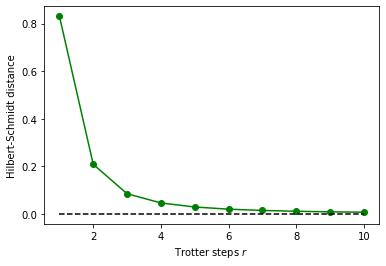

In [9]:
n_qubits = 6
qreg = QuantumRegister(n_qubits)
creg = ClassicalRegister(n_qubits)

t = 1
J = 1
h = 1
ks = [i for i in range(1, 11)]

hs_distances = []
for k in ks:
    circuit_approx = ising_unitary_trotter(qreg, creg, t, k, J, h)
    circuit_exact = ising_unitary_exact(qreg, creg, t, J, h)
    U = execute(circuit_approx, backend=Aer.get_backend('unitary_simulator')).result().get_unitary()
    V = execute(circuit_exact, backend=Aer.get_backend('unitary_simulator')).result().get_unitary()
    hs_distances.append(hs_distance(U, V))
    
plt.plot(ks, hs_distances, color='green', marker='o')
plt.plot(ks, [0]*len(ks), color='black', linestyle='--')
plt.xlabel(r'Trotter steps $r$')
plt.ylabel('Hilbert-Schmidt distance')
plt.show()

### $F_H$ and $F_Q$ cost functions

In [10]:
def uni_cost(n_qubits, n_layers, x0, shots, t, k, J, h, seed_simulator=None):
  # calculates the apporximate and exact values of the cost function F_Q
    
    qreg = QuantumRegister(n_qubits)
    creg = ClassicalRegister(n_qubits)
        
    ansatz = hea(qreg, creg, n_layers, x0)
    ansatz_dg = ansatz.inverse()
    
    u_circ_approx = ising_unitary_trotter(qreg, creg, t, k, J, h)
    u_circ_exact = ising_unitary_exact(qreg, creg, t, J, h) 
    
    measurer = QuantumCircuit(qreg, creg)
    for i in range(n_qubits):
        measurer.measure(i, i)
    
    circuit_approx = ansatz + u_circ_approx + ansatz_dg + measurer
    circuit_exact = ansatz + u_circ_exact + ansatz_dg
    
    job = execute(circuit_approx, shots=shots, seed_simulator=seed_simulator, backend=Aer.get_backend('qasm_simulator'))   
    result = job.result()
    counts = result.get_counts()
    
    zeros_str = '0' * n_qubits
    if zeros_str in counts.keys():
        p0_approx = counts[zeros_str] / shots
    else:
        p0_approx = 0
        
    job = execute(circuit_exact, backend=Aer.get_backend('unitary_simulator'))   
    result = job.result()
    u = result.get_unitary()
    
    zerostate = np.array([1] + [0]*(2**n_qubits - 1))
    p0_exact = abs( (zerostate.conj().T).dot(u).dot(zerostate) )**2
    
    gate_count = ansatz.size() + u_circ_approx.size() + ansatz_dg.size() # excluding measurements
    
    return p0_approx, p0_exact, gate_count

In [11]:
def var_cost(n_qubits, n_layers, x0, hamiltonian_dict, hamiltonian_dict_sq, shots, t, J=1, h=1, seed_simulator=None):
  # calculates the apporximate and exact values of the cost function F_H
    
    qreg = QuantumRegister(n_qubits)
    creg = ClassicalRegister(n_qubits)
    
    ansatz = hea(qreg, creg, n_layers, x0) 
    
    gate_count_1 = 0
    
    
  # calculate <H>^2 

    circuits = []
    multipliers = []
    for operator, multiplier in hamiltonian_dict.items():

        circuit = QuantumCircuit(qreg, creg)
        circuit = circuit + ansatz

        gate_count_1 += circuit.size()
        
        for j in range(n_qubits):
            if operator[j] == 'X':
                circuit.h(j)
                gate_count_1 += 1
            if operator[j] == 'Y':
                circuit.s(j)
                circuit.h(j)
            if operator[j] != 'I':
                circuit.measure(j, j)
                
        circuits.append(circuit)
        multipliers.append(multiplier)

    job = execute(circuits,
                  backend=Aer.get_backend('qasm_simulator'),
                  shots=shots,
                  seed_simulator=seed_simulator)    
    result = job.result()
    counts = result.get_counts()
    
    L = len(multipliers)
    h1 = 0
    for l in range(L):
        h1_local = 0
        for key in counts[l].keys():
            h1_local += counts[l][key] * (-1)**key.count('1') / shots
        h1 += h1_local * multipliers[l]
        

  # calculate <H^2>        

    gate_count_2 = 0
    circuits = []
    multipliers = []
    for operator, multiplier in hamiltonian_dict_sq.items():

        circuit = QuantumCircuit(qreg, creg)
        circuit = circuit + ansatz
        gate_count_2 += circuit.size()

        for j in range(n_qubits):
            if operator[j] == 'X':
                circuit.h(j)
                gate_count_2 += 1
            if operator[j] == 'Y':
                circuit.s(j)
                circuit.h(j)
            if operator[j] != 'I':
                circuit.measure(j, j)
                
        circuits.append(circuit)
        multipliers.append(multiplier)
        
    job = execute(circuits,
                  backend=Aer.get_backend('qasm_simulator'),
                  shots=shots,
                  seed_simulator=seed_simulator)    
    result = job.result()
    counts = result.get_counts()
    
    L = len(multipliers)
    h2 = 0
    for l in range(L):
        h2_local = 0
        for key in counts[l].keys():
            h2_local += counts[l][key] * (-1)**key.count('1') / shots
        h2 += h2_local * multipliers[l]
        
        
    # calculate approximate (<H^2> - <H>^2)
    fun_value_approx = h2 - h1**2
       
    # calculate exact (<H^2> - <H>^2)
    circuit = QuantumCircuit(qreg, creg)
    circuit = circuit + ansatz
    job = execute(circuit,
                  backend=Aer.get_backend('statevector_simulator'))    
    statevector = job.result().get_statevector()
    fun_value_exact = ( statevector.conj().T.dot(ham_sq).dot(statevector) - (statevector.conj().T.dot(ham).dot(statevector))**2 ).real
        
    gate_count = gate_count_1 + gate_count_2    
        
    return fun_value_approx, fun_value_exact, gate_count

### Compare $F_H$ and $F_Q$

In [12]:
n_qubits = 5
n_layers = 4

# Hamiltonian and unitary evolution parameters
J = 1
h = 1
t = 1

shots = 1000 # number of measurements per circuit
ks = [i for i in range(1, 11)] # list of Trotter steps number

n_instances = 10 # number of instances to average over
seeds = random.sample(range(int(1e10)), n_instances) # simulator seeds for each instance
n_pars = 4 * n_qubits * n_layers # number of parameters in HEA
x0s = [[random.uniform(-4*pi, 4*pi) for j in range(n_pars)] for i in range(n_instances)] # initial ansatz parameters for each instance

#### Calculate the maximum possible value of $F_H$ by maximization with a cheaty ansatz

The anzatz is the vector with the components of the form $r_j e^{\imath \phi_j}$

In [13]:
def constrvec(parameters):
    state_vector = []
    for i in range(int(len(parameters)/2)):
        state_vector.append(parameters[2*i]*np.exp(1j*parameters[2*i+1]))
    return np.array(state_vector) / np.linalg.norm(state_vector)

This function returns $-F_H$

In [14]:
def maxvar(parameters, ham):
    statevector = constrvec(parameters)
    t1 = statevector.conj().T.dot(ham).dot(ham).dot(statevector)
    t2 = (statevector.conj().T.dot(ham).dot(statevector))**2
    return -(t1 - t2).real

In [15]:
hermitian_dict = ising_model_dict(n_qubits, J, h)
ham = hamiltonian_dict_to_matrix(hermitian_dict)
ham_sq = ham.dot(ham)
hermitian_dict_sq = hamiltonian_matrix_to_dict(n_qubits, ham_sq)

x0 = [random.uniform(0, 2*pi) for i in range(2**(n_qubits + 1))]
res = minimize(maxvar, x0, args=(ham), method='BFGS')

# this quantity is the maximal possible value of F_H and is used for normalization of plots
normalizer = abs(res.fun)
print('F_H maximal:', normalizer)

F_H maximal: 39.86345818809669


#### Calculate averaged approximate $F_H$

In [16]:
var_difs = []
for i in range(n_instances):
    var_val_approx, var_val_exact, var_gate_count = var_cost(n_qubits, n_layers, x0s[i], hermitian_dict, hermitian_dict_sq, shots, t=t, J=J, h=h, seed_simulator=seeds[i])
    var_difs.append(abs(var_val_approx - var_val_exact) / normalizer)
var_std = sem(var_difs)
var_dis = np.var(var_difs)
var_dif = np.mean(var_difs) 

C:\Users\kardashin\anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
C:\Users\kardashin\anaconda3\lib\site-packages\qiskit\circuit\quantumcircuit.py:933: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  return self.combine(rhs)


#### Calculate averaged approximate $F_Q$ for each Trotter step $r$

In [17]:
uni_difs_k = []
uni_diss_k = []
uni_stds_k = []
uni_gate_counts = []
for k in ks:
    print('k:', k, end='\r')
    uni_difs = []
    for i in range(n_instances):
        uni_val_approx, uni_val_exact, uni_gate_count = uni_cost(n_qubits, n_layers, x0s[i], shots, t=t, k=k, J=J, h=h, seed_simulator=seeds[i])
        uni_difs.append(abs(uni_val_approx - uni_val_exact))
    uni_difs_k.append(np.mean(uni_difs))
    uni_diss_k.append(np.var(uni_difs))
    uni_stds_k.append(sem(uni_difs))
    uni_gate_counts.append(uni_gate_count)

#### Plot the data

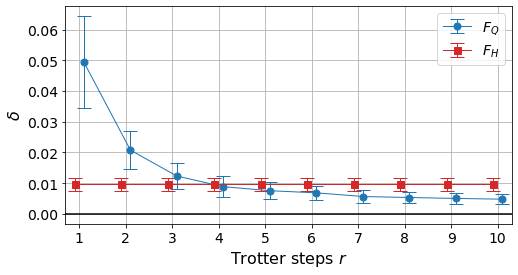

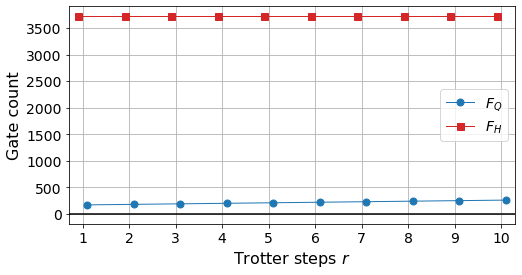

In [18]:
dif = (ks[1] - ks[0]) / 10
l = len(ks)

plt.figure(figsize=(8, 4))
plt.errorbar(np.array(ks) + dif, uni_difs_k, yerr=uni_stds_k, color='tab:blue', label=r'$F_Q$', fmt='o-', capsize=7, linewidth=1, markersize=7)
plt.errorbar(np.array(ks) - dif, [var_dif]*l, yerr=[var_std]*l, color='tab:red', label=r'$F_H$', fmt='s-', capsize=7, linewidth=1, markersize=7)
plt.hlines(y=0, xmin=ks[0]-0.3, xmax=ks[-1]+0.3, colors='black', linestyles='solid')
plt.legend(fontsize=14)
plt.grid()
plt.xlim(ks[0]-0.3, ks[-1]+0.3)
plt.xticks(ks, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'Trotter steps $r$', fontsize=16)
plt.ylabel(r'$\delta$', fontsize=16)
# plt.savefig(str(n_qubits) + 'q-' + str(n_instances) + 'n' + '-delta_k.png', bbox_inches='tight')
# plt.savefig(str(n_qubits) + 'q-' + str(n_instances) + 'n' + '-delta_k.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(np.array(ks) + dif, uni_gate_counts, color='tab:blue', label=r'$F_Q$', marker='o', linewidth=1, markersize=7)
plt.plot(np.array(ks) - dif, [var_gate_count]*l, color='tab:red', label=r'$F_H$', marker='s', linewidth=1, markersize=7)
plt.hlines(y=0, xmin=ks[0]-0.3, xmax=ks[-1]+0.3, colors='black', linestyles='solid')
plt.legend(fontsize=14)
plt.grid()
plt.xlim(ks[0]-0.3, ks[-1]+0.3)
plt.xticks(ks, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'Trotter steps $r$', fontsize=16)
plt.ylabel(r'Gate count', fontsize=16)
plt.show()

## Number of terms in the Ising Hamiltonian

In [19]:
n_qubits = 5
ham = hamiltonian_dict_to_matrix(ising_model_dict(n_qubits, 1, 1))

print('N^2_terms expected:', 1 - 3*n_qubits + 2*n_qubits**2)
print('N^2_terms actual:', len(hamiltonian_matrix_to_dict(n_qubits, ham.dot(ham))))
print()

n_X = 0
for key in hamiltonian_matrix_to_dict(n_qubits, ham.dot(ham)).keys():
    for char in key:
        if char == 'X':
            n_X += 1
print('N_x expected:', n_qubits * (2*n_qubits - 3))
print('N_x actual:', n_X)

N^2_terms expected: 36
N^2_terms actual: 36

N_x expected: 35
N_x actual: 35
